<a href="https://colab.research.google.com/github/jhmartire/Predict-Times-Series-Test/blob/master/Rossmann_Sales_productors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.0 IMPORTS

In [1]:
!pip install inflection

In [2]:
import io
import pandas as pd
import io
import numpy as np 
import inflect
import mmap
import math
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as Image



from google.colab import files
from google.colab import drive 
#drive.mount('/content/drive')


##0.2. Loading data


In [3]:
df_sales_raw = pd.read_csv( '/content/drive/My Drive/Data Science em Producao /train.csv')
df_store_raw = pd.read_csv( '/content/drive/My Drive/Data Science em Producao /store.csv')

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_raw.shape

(1017209, 18)

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
945595,861,3,2013-03-06,0,0,0,1,0,0,c,c,740.0,NaN,NaN,1,14.0,2013.0,"Mar,Jun,Sept,Dec"


#1.0. PASSO 1 - DESCRICAO DE DADOS


In [6]:
df1 = df_raw.copy()

##1.1.Rename Columns

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
          'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
          'CompetitionDistance', 'CompetitionOpenSinceMonth',
          'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
          'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore ( x )  

cols_new = list( map( snakecase, cols_old) )

#rename
df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

##1.2. Data Dimensions

In [10]:
  print( 'Number of Rows: {}' .format( df1.shape[0] ) )
  print( 'Number of Cols: {}' .format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


##1.3. Data Types

In [11]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

##1.4. Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

##1.5. Fillout NA

In [13]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
253404,239,6,2014-12-13,5049,500,1,0,0,0,d,c,610.0,NaN,NaN,0,NaN,NaN,NaN


In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan (x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                               
#promo2_since_week   
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan (x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval    
month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}


df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [17]:
df1.sample(5).T

,237629,3658,579013,275448,723952
store,376,314,1114,877,1103
day_of_week,2,2,3,4,6
date,2014-12-30 00:00:00,2015-07-28 00:00:00,2014-01-29 00:00:00,2014-11-20 00:00:00,2013-09-21 00:00:00
sales,9736,6178,13948,4923,3510
customers,1057,579,2227,764,282
open,1,1,1,1,1
promo,0,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,1,1,0,0,0
store_type,a,a,a,a,d


##1.6. Change Types


In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)


df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


##1.7. Descriptive Statistical


In [19]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])


##1.7.1 Numerical Attributes

In [20]:
#Central Tendency  -  mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean) ).T
ct2 = pd.DataFrame(num_attributes.apply( np.median) ).T


#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std) ).T
d2 = pd.DataFrame(num_attributes.apply( min ) ).T
d3 = pd.DataFrame(num_attributes.apply( max ) ).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


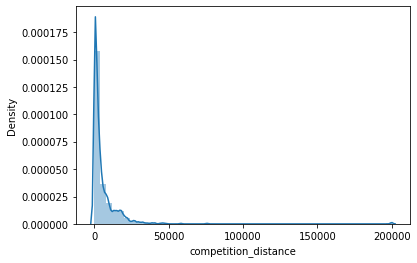

In [21]:
sns.distplot( df1['competition_distance'] ) 

##1.7.2 Categorical Attributes


In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

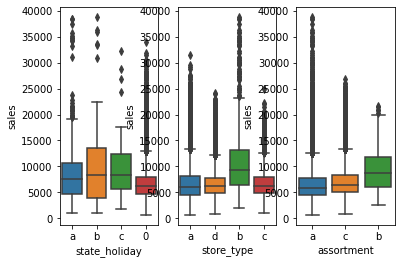

In [23]:
aux1 = df1[(df1['state_holiday'] !='0') & (df1['sales'] >0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1 )

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1 )

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1 )



#2.0. Passo 2 - FEATURE ENGINEERING 

---



## 2.1. Mapa Mental de Hipoteses
  

In [ ]:
uploaded = files.upload()

In [ ]:
Image('MindMapHypothesis.png', width = 100)

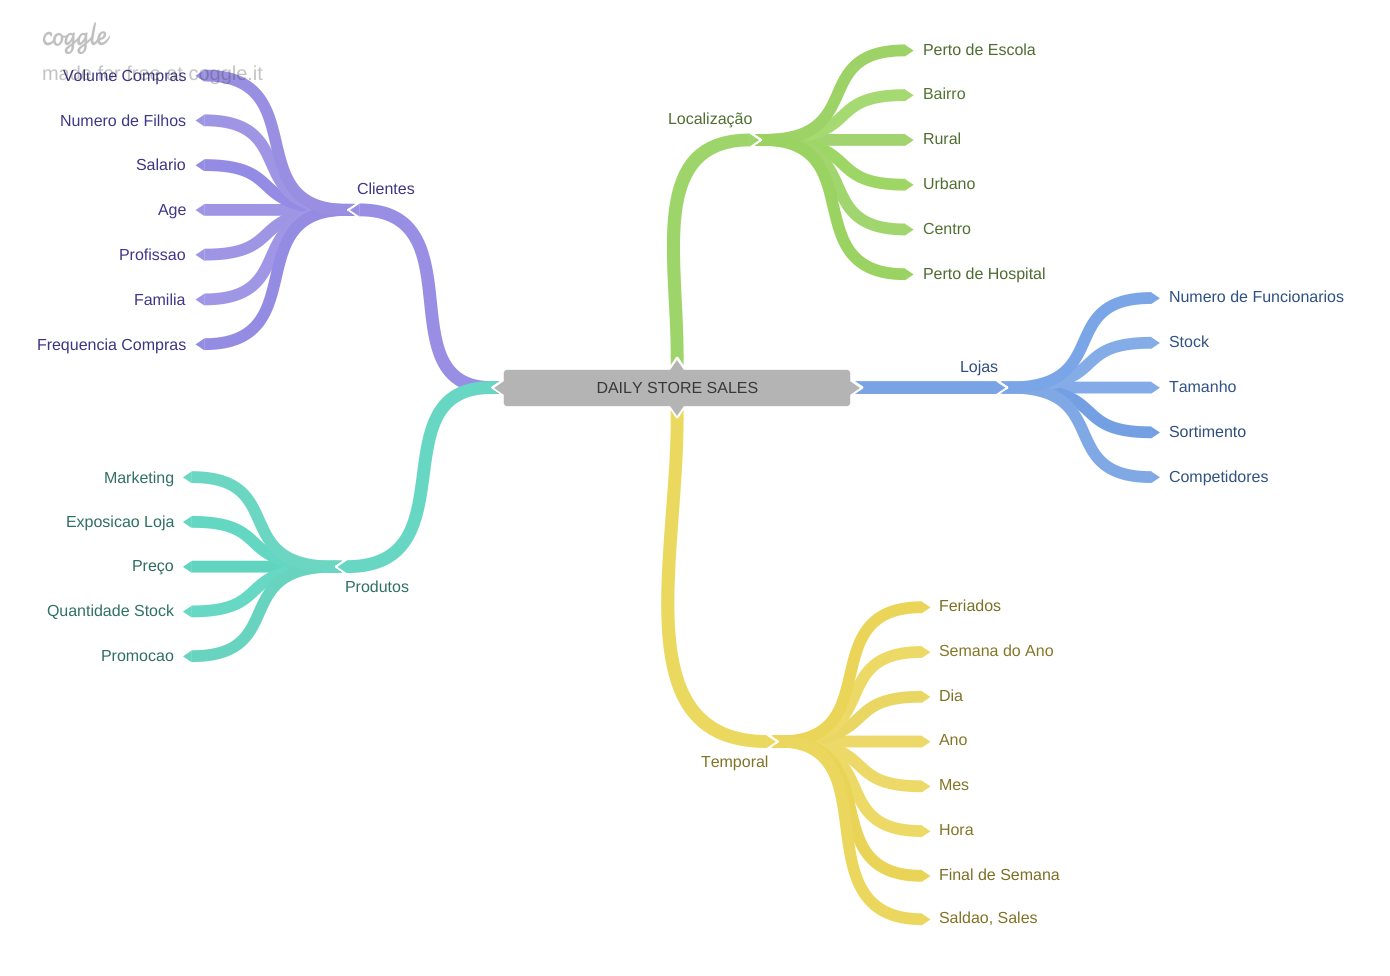

## 2.1. Criacao das Hipoteses



###2.1.1. Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.



###2.1.2. Hipoteses Produto

**1**. Lojas que investem mais em Marketing deveriam vender mais.

**2**. Lojas com maior exposicao de produto deveriam vender mais.

**3**. Lojas com produtos com preco menor deveriam vender mais.

**4**. Lojas com promocoes mais agressivas (descontos maiores), deveriam vender mais.

**5**. Lojas com promocao ativas por mais tempo  deveriam vender mais.

**6**. Lojas com mais dias de promocao deveriam vender mais.

**7**. Lojas com mais promocoes consecutivas deveriam vender mais.


###2.1.3. Hipoteses Tempo

In [ ]:
**1.** Lojas abertas durante o feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo do ano.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam  mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveruan vender menos durante os feriados escolares.


## 2.2. Lista final de Hipoteses


**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.



**4.** Lojas com promocao ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas com mais promocoes consecutivas deveriam vender mais.


**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo do ano.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam  mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveruan vender menos durante os feriados escolares.
